In [1]:
import pandas as pd
df = pd.read_feather('data/TRF01_IW976-0032_1636056007.fthr') #performance
# df = pd.read_feather('data/TRF10_IW976-0032_1643202007.fthr') #details
# df = pd.read_feather('data/T7_ANALOGMAX-1_1643202000.fthr') #clear
x = df.iloc[:, 1]
t = df.iloc[:, 0] / 1000
fs = 1 / t[1]

In [2]:
import numpy as np
from scipy.signal import iirfilter, lfilter, periodogram, stft
from scipy.fft import fft, next_fast_len, fftfreq
from numpy.lib.stride_tricks import sliding_window_view

import matplotlib.pyplot as plt
# %matplotlib notebook
figsize = [19, 5]

In [3]:
def getCS_fast(x, fs, approxCoh=True):
    fMin, R, Nw, w, D = getParams(fs)
    
    # STFT with with Hanning window and with Hanning multiplied by Dirichlet kernel
    X_w = stft(x, fs=fs, window=w, nperseg=Nw, noverlap=Nw - R, nfft=Nw, return_onesided=True)[-1]
    f, t, x_w_d = stft(x, fs=fs, window=w * D, nperseg=Nw, noverlap=Nw - R, nfft=Nw, return_onesided=True)

    if approxCoh:
        # here I save some computation time by removing the frequencies below fMin.
        # later I have to implement the approximation to the coherence by neglecting the 
        # frequency shift -> CCoh = CS / CS[0, :] rather than -> CCoh = CS / sqrt(CS[0, :] * CS[0, k-(a * Nw) / (M * R)] 
        X_w = X_w[f >= fMin, :]
        x_w_d = x_w_d[f >= fMin, :]
    
    # Cyclcic Spectrum
    CS = np.fft.fft(np.conjugate(X_w) * x_w_d, axis=1).T
    # Modulation frequency
    alpha = np.fft.fftfreq(x_w_d.shape[1], R / fs)
    CS = CS[alpha >= 0, :]

    # here I implemented the normalization but did not find it useful - the results' improvement is not impressive.
    # normalizingFactor = fft((w**2) * D, int(R * (1 + (x.size - Nw) / R)))[:CS.shape[0]]
    # normalizingFactor *= fs * x_w_d.shape[1]
    # CS = (CS.T / normalizingFactor).T
    
    # Cyclic Coherence
    if approxCoh:
        CCoh = CS / CS[0, :]
    else:
        inds = np.atleast_2d(np.arange(f.size)) - np.atleast_2d((np.arange(CS.shape[0]) * Nw) / (R * alpha.size)).T
        inds = inds.astype(int)
        CCoh = CS / np.sqrt(np.abs(CS[0, :] * CS[0, inds]))
        CS = CS[:, f >= fMin]
        CCoh = CCoh[:, f >= fMin]
                         
    alpha = alpha[alpha >= 0]
    f = f[f >= fMin]

    return CS, CCoh, f, alpha

In [4]:
def getParams(fs, alphaMax=1000, df=100, fMin=5e+4):
    # alphaMax - max modulation frequency
    # df - carrier frequency resolution
    # fMin - min carrier frequency

    # STFT windows' hop
    R = int(np.floor(fs / (2 * alphaMax))) #shift of the stft
    # STFT window length
    Nw = int(fs / df)
    # number of STFT windows
#     M = int((x.size - Nw) / R + 1)

    # hannind window
    w = np.hanning(Nw)
    # Dirichlet kernel parameter
    P = int(np.round((Nw - 1) / (2 * R)))
    # Dirichlet kernel
    D = np.sum(
        [np.exp(2 * np.pi * 1j * p *(np.arange(Nw) - Nw / 2) / Nw) for p in np.arange(- P, P + 1)], 
        axis=0
    )
    D = D.real
    return fMin, R, Nw, w, D

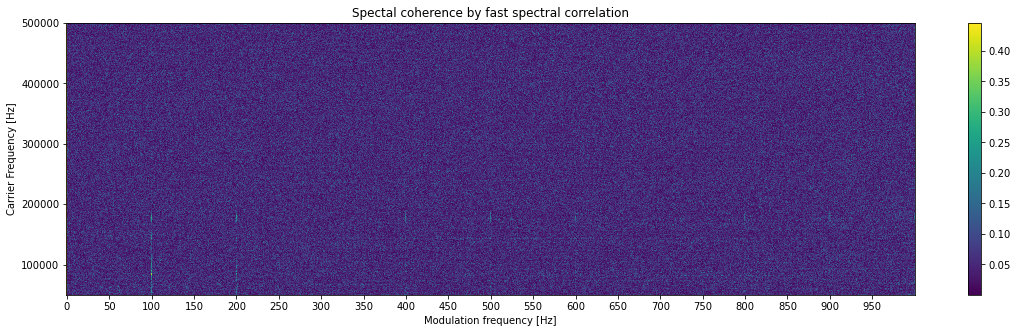

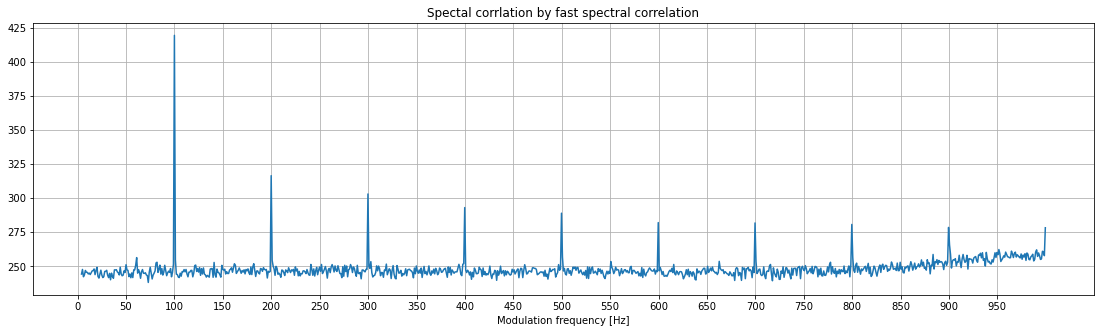

In [5]:
CS, CCoh, f_fast, alpha = getCS_fast(x, fs)
EES_CS = np.sum(np.abs(CS), axis=1)
EES_CCoh = np.sum(np.abs(CCoh), axis=1)
cond = alpha > 3
CCoh_abs = np.abs(CCoh.T)

plt.figure(figsize=figsize)
plt.pcolormesh(alpha, f_fast, CCoh_abs, shading='auto', vmax=np.percentile(CCoh_abs, 99.9))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency [Hz]')
plt.title('Spectal coherence by fast spectral correlation')
plt.xticks(np.arange(0, 1000, 50))
plt.colorbar()
plt.show()

plt.figure(figsize=figsize)
plt.plot(alpha[cond], np.sum(CCoh_abs, axis=0)[cond])
plt.xlabel('Modulation frequency [Hz]')
plt.title('Spectal corrlation by fast spectral correlation')
plt.xticks(np.arange(0, 1000, 50))
plt.grid()
plt.show()

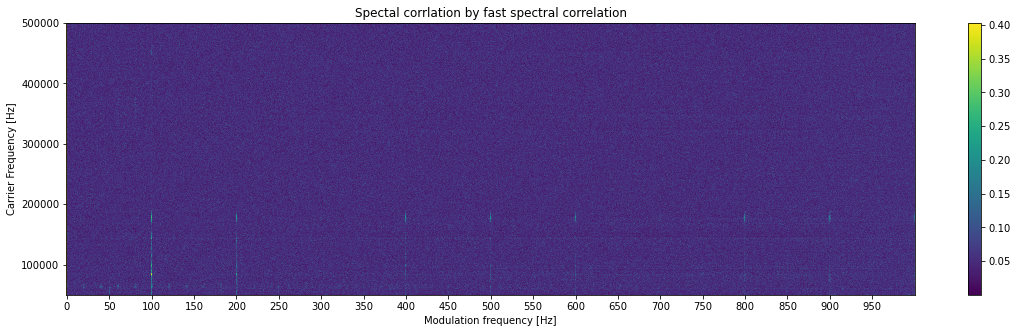

In [6]:
from scipy.signal import medfilt2d

plt.figure(figsize=figsize)
y = medfilt2d(CCoh_abs, (15, 1))
plt.pcolormesh(alpha, f_fast, y, shading='auto', vmax=np.percentile(y, 99.9))
plt.xlabel('Modulation frequency [Hz]')
plt.ylabel('Carrier Frequency [Hz]')
plt.title('Spectal corrlation by fast spectral correlation')
plt.xticks(np.arange(0, 1000, 50))
plt.colorbar()
plt.show()

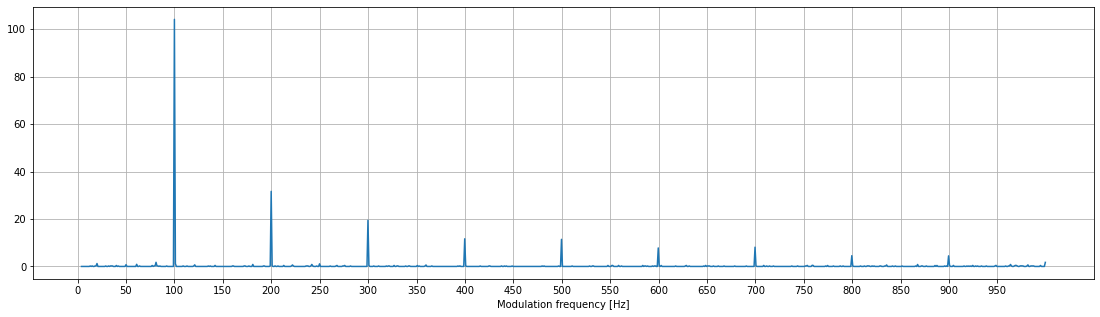

In [8]:
cond = (alpha > 3)
z = CCoh_abs.copy()
lim = 0.2
# z = y.copy()
# lim = 0.1
z[z < lim] = 0
plt.figure(figsize=figsize)
plt.plot(alpha[cond], np.sum(z, axis=0)[cond])
plt.xticks(np.arange(0, 1000, 50))
plt.xlabel('Modulation frequency [Hz]')
plt.grid()
plt.show()